In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import models
import utils
import glob
import visualize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

c:\users\fanhangming\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Preprocess the image, linear normalize to -1~1, post_process turn it back to 0~1

In [2]:
def pre_process(img):
    return img * 2 - 1
def post_process(img):
    return (img + 1) / 2

#### Load MNIST dataset and show example images, choose ```batch_size```

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./dataset/MNIST_data', one_hot=True)

batch_size = 128

Extracting ./dataset/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data\t10k-labels-idx1-ubyte.gz


#### Function to create noisely initionalization of the generator in shape[batch_size, noise_dim]

In [4]:
def sample_noise(batch_size, dim):
    return np.random.uniform(-1, 1, size=(batch_size, dim))

#### Function to run a GAN, every n_critic times to train discriminator, train generator once

In [5]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10, n_critic=5):
    
    max_iter = mnist.train.num_examples*num_epoch // (batch_size * n_critic)
    for it in range(max_iter):
        if it % show_every == 0:
            noise_z = sample_noise(batch_size, noise_dim)
            samples = sess.run(G_sample, feed_dict={z:noise_z})
            fig = visualize.show_images(samples[:16])
            plt.show()
            print()
        
        for i in range(n_critic):
            noise_z = sample_noise(batch_size, noise_dim)
            minibatch = np.reshape(mnist.train.next_batch(batch_size)[0], [-1, 28, 28, 1])
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x:pre_process(minibatch), z:noise_z})
        
        
        noise_z = sample_noise(batch_size, noise_dim)            
        _, G_loss_curr = sess.run([G_train_step, G_loss,], feed_dict={z:noise_z})
        
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it, max_iter,D_loss_curr, G_loss_curr))
    print('Final images')
    noise_z = sample_noise(100, noise_dim)
    samples = sess.run(G_sample, feed_dict={z:noise_z})
    
    fig = visualize.show_images(samples, final="./images/WGAN-GP_231")
    plt.show()

### Get the generator and discriminator model and create the input

In [25]:
tf.reset_default_graph()

noise_dim = 96

x = tf.placeholder(tf.float32, [None, 28, 28, 1])
z = tf.placeholder(tf.float32, [None, noise_dim])
#generator = models.generator_WGAN
#discriminator = models.discriminator_WGAN
generator = models.generator_231
#discriminator = models.discriminator_WGAN_231
discriminator = models.discriminator_DCGAN_231

G_sample = generator(z, reuse=False)
logits_real = discriminator(x, reuse=False)
logits_fake = discriminator(G_sample)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

## WGAN-PG loss
##### WGAN-GP
- batch_size = 64
- noise_dim = 100
- n_critic = 3
- leaning_rate = 1e-3

##### DCGAN
- batch_size = 128
- noise_dim = 96
- n_critic = 1
- learning_rate = 1e-3

In [28]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)
    
    lam = 10
    shape = tf.concat((tf.shape(x)[0:1], tf.tile([1], [x.shape.ndims - 1])), axis=0)
    eps = tf.random_uniform(shape=shape, minval=0., maxval=1.)
    x_hat = x + eps * (G_sample - x)
   
    with tf.variable_scope('', reuse=True) as scope:
        pred = discriminator(x_hat)
        grad_D_x_hat = tf.gradients(pred, x)[0]
    
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=tf.range(1, x.shape.ndims)))
    grad_pen = lam * tf.reduce_mean((grad_norm - 1.) ** 2)
    
    D_loss += grad_pen
    
    return D_loss, G_loss

def dcgan_loss(logits_real, logits_fake, batch_size, x, G_smaple):
    
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real))
    D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake))
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake))
    return D_loss, G_loss
    
D_loss, G_loss  =dcgan_loss(logits_real, logits_fake, batch_size, x, G_sample)
#D_loss, G_loss  =wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample)
D_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(D_loss, var_list=D_vars)
G_train_step = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5).minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

## Train part

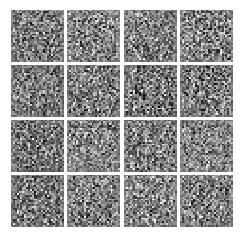


Iter: 0/5729, D: 0.7965, G:1.217
Iter: 50/5729, D: 0.0799, G:6.131
Iter: 100/5729, D: 0.4656, G:1.72
Iter: 150/5729, D: 0.5948, G:2.11
Iter: 200/5729, D: 0.8245, G:2.78


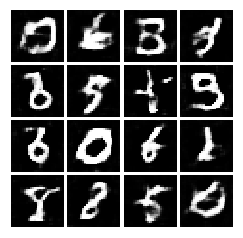


Iter: 250/5729, D: 0.7357, G:1.953
Iter: 300/5729, D: 0.6359, G:2.301
Iter: 350/5729, D: 0.5797, G:1.969
Iter: 400/5729, D: 0.7111, G:1.719
Iter: 450/5729, D: 0.5709, G:2.695


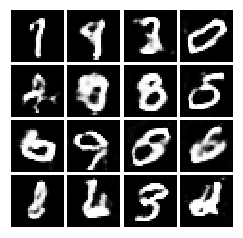


Iter: 500/5729, D: 0.512, G:1.351
Iter: 550/5729, D: 0.6594, G:2.07
Iter: 600/5729, D: 0.6287, G:1.249
Iter: 650/5729, D: 1.345, G:1.439
Iter: 700/5729, D: 0.4923, G:1.897


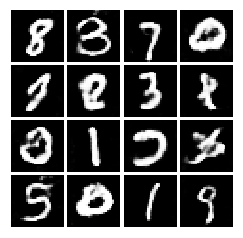


Iter: 750/5729, D: 0.6802, G:1.702
Iter: 800/5729, D: 0.6373, G:2.086
Iter: 850/5729, D: 0.4786, G:2.234
Iter: 900/5729, D: 0.6186, G:1.77
Iter: 950/5729, D: 0.5363, G:1.829


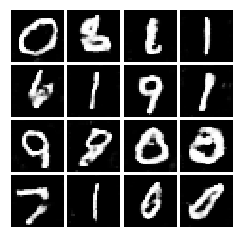


Iter: 1000/5729, D: 0.6071, G:4.422
Iter: 1050/5729, D: 0.6392, G:3.043
Iter: 1100/5729, D: 0.8311, G:1.218
Iter: 1150/5729, D: 0.8853, G:1.586
Iter: 1200/5729, D: 0.6863, G:1.363


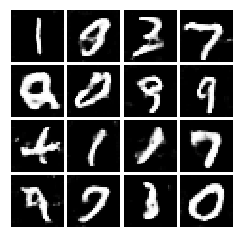


Iter: 1250/5729, D: 0.7218, G:3.479
Iter: 1300/5729, D: 0.6985, G:1.714
Iter: 1350/5729, D: 0.5356, G:2.302
Iter: 1400/5729, D: 0.4526, G:3.064
Iter: 1450/5729, D: 0.829, G:1.716


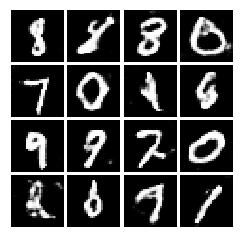


Iter: 1500/5729, D: 0.5643, G:4.462
Iter: 1550/5729, D: 0.6161, G:2.697
Iter: 1600/5729, D: 0.706, G:1.897
Iter: 1650/5729, D: 0.43, G:2.211
Iter: 1700/5729, D: 0.4761, G:2.363


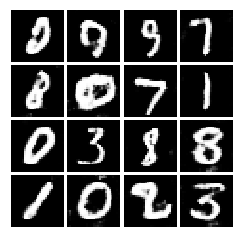


Iter: 1750/5729, D: 0.5741, G:2.501
Iter: 1800/5729, D: 0.506, G:2.228
Iter: 1850/5729, D: 0.5143, G:2.908
Iter: 1900/5729, D: 0.4352, G:2.484
Iter: 1950/5729, D: 0.3431, G:2.963


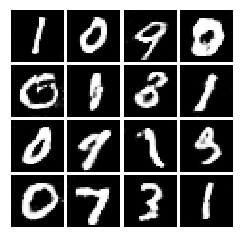


Iter: 2000/5729, D: 0.3047, G:1.887
Iter: 2050/5729, D: 0.4378, G:2.732
Iter: 2100/5729, D: 0.4089, G:1.991
Iter: 2150/5729, D: 0.6888, G:1.478
Iter: 2200/5729, D: 0.5441, G:2.224


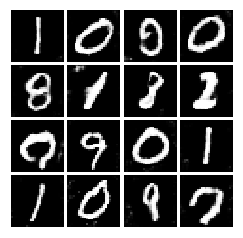


Iter: 2250/5729, D: 0.5551, G:3.249
Iter: 2300/5729, D: 0.4654, G:1.49
Iter: 2350/5729, D: 0.3991, G:3.429
Iter: 2400/5729, D: 0.5041, G:1.89
Iter: 2450/5729, D: 0.3931, G:3.875


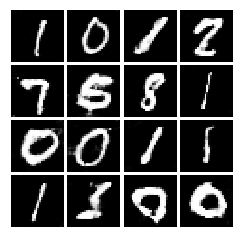


Iter: 2500/5729, D: 0.3221, G:2.986
Iter: 2550/5729, D: 0.4045, G:3.041
Iter: 2600/5729, D: 0.3583, G:3.055
Iter: 2650/5729, D: 0.5639, G:5.119
Iter: 2700/5729, D: 0.3535, G:2.92


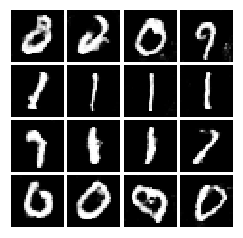


Iter: 2750/5729, D: 0.3424, G:2.382
Iter: 2800/5729, D: 0.3815, G:3.515
Iter: 2850/5729, D: 0.4257, G:3.053
Iter: 2900/5729, D: 0.338, G:3.043
Iter: 2950/5729, D: 0.2933, G:3.274


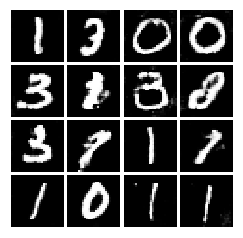


Iter: 3000/5729, D: 0.3685, G:3.647
Iter: 3050/5729, D: 0.2412, G:3.076
Iter: 3100/5729, D: 0.2689, G:3.105
Iter: 3150/5729, D: 0.4195, G:3.047
Iter: 3200/5729, D: 0.3129, G:4.572


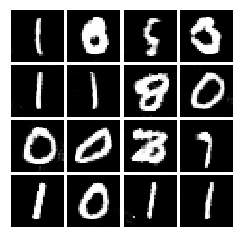


Iter: 3250/5729, D: 0.2112, G:3.872
Iter: 3300/5729, D: 0.5898, G:5.758
Iter: 3350/5729, D: 0.3585, G:3.887
Iter: 3400/5729, D: 0.3437, G:2.764
Iter: 3450/5729, D: 0.3052, G:3.38


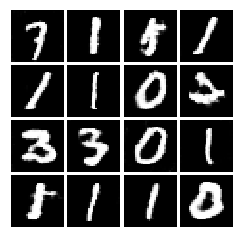


Iter: 3500/5729, D: 0.267, G:2.874
Iter: 3550/5729, D: 0.5558, G:3.602
Iter: 3600/5729, D: 0.8942, G:3.07
Iter: 3650/5729, D: 0.8201, G:1.112
Iter: 3700/5729, D: 0.3696, G:3.067


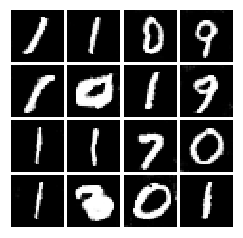


Iter: 3750/5729, D: 0.3969, G:2.905
Iter: 3800/5729, D: 0.3996, G:2.206
Iter: 3850/5729, D: 0.3197, G:4.504
Iter: 3900/5729, D: 0.2717, G:3.145
Iter: 3950/5729, D: 0.2021, G:3.682


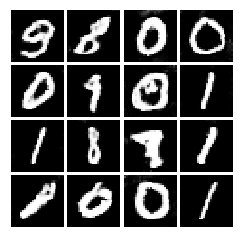


Iter: 4000/5729, D: 0.1328, G:4.651
Iter: 4050/5729, D: 0.179, G:4.694
Iter: 4100/5729, D: 0.2826, G:3.147
Iter: 4150/5729, D: 0.5481, G:2.692
Iter: 4200/5729, D: 0.385, G:5.76


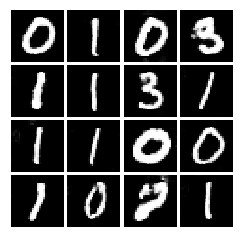


Iter: 4250/5729, D: 0.2285, G:3.272
Iter: 4300/5729, D: 0.3851, G:3.232
Iter: 4350/5729, D: 0.2125, G:5.073
Iter: 4400/5729, D: 0.1975, G:4.023
Iter: 4450/5729, D: 0.4386, G:4.273


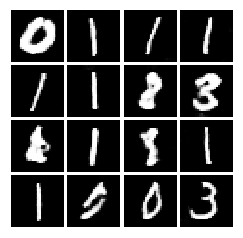


Iter: 4500/5729, D: 0.1684, G:4.426
Iter: 4550/5729, D: 0.2435, G:4.799
Iter: 4600/5729, D: 0.2622, G:3.557
Iter: 4650/5729, D: 0.2348, G:4.452
Iter: 4700/5729, D: 0.1855, G:4.32


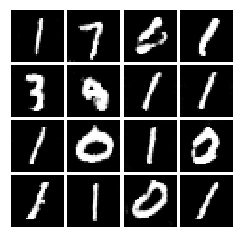


Iter: 4750/5729, D: 0.3005, G:4.18


KeyboardInterrupt: 

In [29]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, batch_size=batch_size, num_epoch=20, n_critic=1)